In [1]:
# First try to use the data to train a model
import numpy as np
import random
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed, Bidirectional, BatchNormalization
from keras import regularizers
from keras.optimizers import SGD
import pandas as pd
import matplotlib as mpl
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import math
from tensorflow.keras import regularizers
import gc
from sklearn.metrics import r2_score

print(tf.config.experimental.list_physical_devices('GPU'))

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


In [2]:
# Load the dataset from the file

SensorValues = pd.read_csv('mySensorData2.csv', header = None)
LocationValues = pd.read_csv('myLocationData2.csv', header = None)
# SortedVal = pd.read_csv('mySortedVal.csv', header = None)
# SortedTest = pd.read_csv('mySortedTest.csv', header = None)

# SensorValues.head()
# LocationValues.head()
# SortedValues.head()

sensor_arr = SensorValues.values
location_arr = LocationValues.values
# sorted_val= SortedVal.values
# sorted_test= SortedTest.values

print(sensor_arr.shape)
print(location_arr.shape)
# # print(sorted_val.shape)
# # print(sorted_test.shape)

print(np.min(sensor_arr))
print(np.max(sensor_arr))


(2880000, 480)
(2880000, 3)
0.0
0.262454


In [3]:
def inverse_min_max_scaling(data, min_val, max_val):
    arr = (max_val - min_val) * data + min_val
    return arr

In [4]:
def min_max_scaler(data):
    # Calculate the minimum and maximum values of the data
    
    min_val = np.min(data)
    max_val = np.max(data)
    
    scaled_data = (data - min_val) / (max_val - min_val)
    
    return scaled_data

C:\Users\win10\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


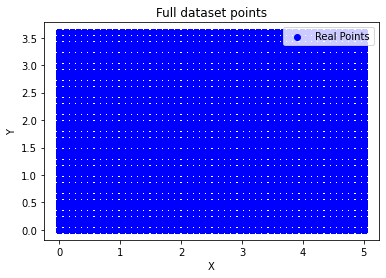

In [5]:
# Preview the Location of the real data points

plt.scatter(location_arr[:,0], location_arr[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Full dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()
        


In [6]:
train_size_per = 90    # 70% of the data is used for training
                        # 15% of the data is used for validation
                        # 15% of the data is used for testing
rotation_per_position = 16

reads_per_position = 100   

total_values_per_position = rotation_per_position * reads_per_position              


X = min_max_scaler(sensor_arr)
Y_loc_0 = location_arr[:,0]
Y_loc_1 = location_arr[:,1]
Y_rot = location_arr[:,2]
# Y_loc_0 = (location_arr[:,0])
# Y_loc_1 = (location_arr[:,1])
# Y_rot = (location_arr[:,2])

Y = np.zeros((Y_loc_0.shape[0], 3))

for i in range(0, Y_loc_0.shape[0]):
    Y[i,0] = Y_loc_0[i]
    Y[i,1] = Y_loc_1[i]
    Y[i,2] = Y_rot[i]


data_sen_size = int(X.shape[0])
data_sen_size_2 = int(X.shape[1])

data_loc_size = int(Y.shape[0])
data_loc_size_2 = int(Y.shape[1])



val_size = int(data_sen_size * (((100 - train_size_per)/100)))
# test_size = int(data_sen_size * (((100 - train_size_per)/100)))
train_size = int(data_sen_size * (train_size_per/100))

print("train_size: ", train_size)
print("val_size: ", val_size)
# print("test_size: ", test_size)



train_size:  2592000
val_size:  288000


In [7]:
data_size_rotation = int(data_sen_size / total_values_per_position)

val_test_size_per = int(data_size_rotation * ((100 - train_size_per)/100))

random_numbers = random.sample(range(0, data_size_rotation), val_test_size_per)

random.shuffle(random_numbers)

halfway = len (random_numbers) // 2
print(halfway)

# test_random = random_numbers[:halfway]
# val_random = random_numbers[halfway:]
val_random = random_numbers

print(val_size)

val_numbers = np.zeros((val_size, 1))
# test_numbers = np.zeros((test_size, 1))

n_val = 0
for i in val_random:
    for j in range(0, total_values_per_position):
        val_numbers[n_val] = i * total_values_per_position + j
        n_val = n_val + 1

# n_test = 0
# for i in test_random:
#     for j in range(0, total_values_per_position):
#         test_numbers[n_test] = i * total_values_per_position + j
#         n_test = n_test + 1
        
val_sorted = np.sort(val_numbers, axis=0)
# test_sorted = np.sort(test_numbers, axis=0)

90
288000


In [8]:
import csv
with open('mySortedVal127.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for row in val_sorted:
        writer.writerow(row)
     
# with open('mySortedTest120.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     for row in test_sorted:
#         writer.writerow(row)   

# SortedVal = pd.read_csv('mySortedVal123.csv', header = None)
# SortedTest = pd.read_csv('mySortedTest116.csv', header = None)

# val_sorted= SortedVal.values
# test_sorted= SortedTest.values

In [9]:
X_train = np.zeros((train_size, data_sen_size_2))
Y_train = np.zeros((train_size, data_loc_size_2))

X_val = np.zeros((val_size, data_sen_size_2))
Y_val = np.zeros((val_size, data_loc_size_2))

# X_test = np.zeros((test_size, data_sen_size_2))
# Y_test = np.zeros((test_size, data_loc_size_2))

n_test = 0
n_train = 0
n_val = 0

for i in range (0, data_sen_size):
    # percentage = i / data_sen_size * 100
    # print("Progress: " + str(percentage) + "%")    
    if i in val_sorted:
        X_val[n_val] = X[i]
        Y_val[n_val] = Y[i]
        n_val = n_val + 1
    else:
        X_train[n_train] = X[i]
        Y_train[n_train] = Y[i]
        n_train = n_train + 1

In [10]:
# Merge the X_val and X_test into X_val_test and Y_val and Y_test into Y_val_test
# X_val_test = np.concatenate((X_val, X_test), axis=0)
# Y_val_test = np.concatenate((Y_val, Y_test), axis=0)

In [11]:
SensorTestValues = pd.read_csv('mySensorData3.csv', header = None)
LocationTestValues = pd.read_csv('myLocationData3.csv', header = None)

print(sensor_arr.shape)
print(location_arr.shape)
# # print(sorted_val.shape)
# # print(sorted_test.shape)

print(np.min(SensorTestValues))
print(np.max(SensorTestValues))

location_test_arr = LocationTestValues.values
sensor_test_arr = SensorTestValues.values

X_test = min_max_scaler(sensor_test_arr)
Y_test_loc_0 = location_test_arr[:,0]
Y_test_loc_1 = location_test_arr[:,1]
Y_test_rot = location_test_arr[:,2]
# Y_loc_0 = (location_arr[:,0])
# Y_loc_1 = (location_arr[:,1])
# Y_rot = (location_arr[:,2])

Y_test = np.zeros((Y_test_loc_0.shape[0], data_loc_size_2))

# X_test = np.zeros((Y_test_loc_0.shape[0], data_sen_size_2))
# Y_test = np.zeros((test_size, data_loc_size_2))


for i in range(0, Y_test_loc_0.shape[0]):
    Y_test[i,0] = Y_test_loc_0[i]
    Y_test[i,1] = Y_test_loc_1[i]
    Y_test[i,2] = Y_test_rot[i]
    

    
print(X_test.shape)
print(Y_test.shape)

(2880000, 480)
(2880000, 3)
0.0
0.26201
(10000, 480)
(10000, 3)


C:\Users\win10\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


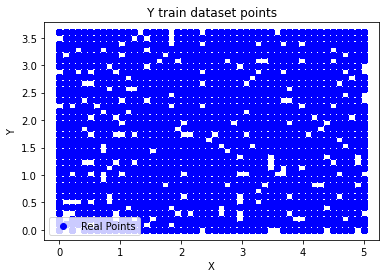

In [12]:
# Split the data into training and testing sets
plt.scatter(Y_train[:,0], Y_train[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y train dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

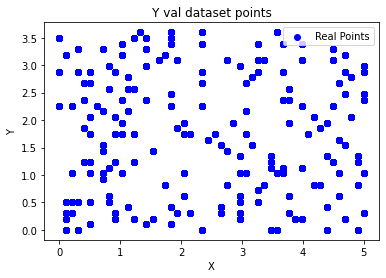

In [13]:
plt.scatter(Y_val[:,0], Y_val[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y val dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

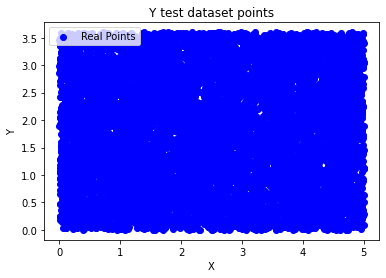

In [14]:
plt.scatter(Y_test[:,0], Y_test[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y test dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

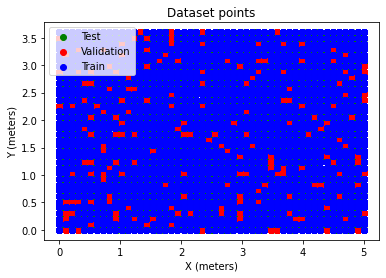

In [15]:
plt.scatter(Y_test[:,0], Y_test[:,1], color='green', label='Test')
plt.scatter(Y_val[:,0], Y_val[:,1], color='red', label='Validation')
plt.scatter(Y_train[:,0], Y_train[:,1], color='blue', label='Train')

# # Set the x-axis label to "X"
plt.xlabel('X (meters)')

# # Set the y-axis label to "Y"
plt.ylabel('Y (meters)')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [16]:
# Machine Learning - Euclidean Loss Functions for X and Y

def loss_function_xy_euclidean(y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = tf.reduce_mean(K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true)))
    return distance

In [17]:
# Machine Learning - Euclidean Metric Functions for X and Y

def metric_function_xy_euclidean (y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = tf.reduce_mean(K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true)))
    return distance

In [18]:
# Machine Learning - Loss Functions for theta

def loss_function_theta(y_true, y_pred):
    delta_angles = y_pred - y_true
    # Wrap delta_angles to the [-pi, pi] range
    wrapped_diff = tf.atan2(tf.sin(delta_angles), tf.cos(delta_angles))
    return tf.reduce_mean(tf.square(wrapped_diff))

In [19]:
def metric_function_theta(y_true, y_pred):
    delta_angles = y_pred - y_true
    # Wrap delta_angles to the [-pi, pi] range
    wrapped_diff = tf.atan2(tf.sin(delta_angles), tf.cos(delta_angles))
    return tf.reduce_mean(K.abs(wrapped_diff))

In [20]:
def loss_function_xy_mse(y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = tf.reduce_mean(K.square(K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true))))
    return distance


In [21]:
def loss_function_xy_mae(y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = tf.reduce_mean(K.abs(K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true))))
    return distance

In [22]:
def loss_function_xy_huber(y_true, y_pred, delta=1.0):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    x_true = xy_true[:, 0]
    y_true = xy_true[:, 1]
    x_pred = xy_pred[:, 0]
    y_pred = xy_pred[:, 1]
    error = tf.reduce_mean(K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true)))
    is_small_error = K.abs(error) < delta
    squared_loss = 0.5 * K.square(error)
    linear_loss = delta * (K.abs(error) - 0.5 * delta)
    return tf.reduce_mean(tf.where(is_small_error, squared_loss, linear_loss))

In [23]:
def loss_function_theta_mse(y_true, y_pred):
    delta_angles = y_pred - y_true
    wrapped_diff = tf.atan2(tf.sin(delta_angles), tf.cos(delta_angles))
    return tf.reduce_mean(K.square(wrapped_diff))

In [24]:
def loss_function_theta_mae(y_true, y_pred):
    delta_angles = y_pred - y_true
    wrapped_diff = tf.atan2(tf.sin(delta_angles), tf.cos(delta_angles))
    return tf.reduce_mean(K.abs(wrapped_diff))

In [25]:
def loss_function_theta_huber(y_true, y_pred, delta=1.0):
    delta_angles = y_pred - y_true
    wrapped_diff = tf.atan2(tf.sin(delta_angles), tf.cos(delta_angles))
    error = wrapped_diff
    is_small_error = K.abs(error) < delta
    squared_loss = 0.5 * K.square(error)
    linear_loss = delta * (K.abs(error) - 0.5 * delta)
    return tf.reduce_mean(tf.where(is_small_error, squared_loss, linear_loss))


In [26]:
#Early Stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,  # Stop training if no improvement after 10 epochs
    restore_best_weights=True  # Restore the best model weights
)

In [27]:
#Model Checkpoint

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=True,
    monitor='val_loss',
)

In [28]:
# Learning Rate Schedule

def lr_schedule(epoch):
    if epoch < 2:
        return 0.0001
    elif epoch < 10:
        return 0.00001
    elif epoch < 20:
        return 0.000001
    elif epoch < 40:
        return 0.0000001
    elif epoch < 75:
        return 0.00000001
    else:
        return 0.000000001
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [29]:
# TensorBoard Logging

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True,
)

In [30]:
# randomize the data

data = list(zip(X_train, Y_train))
random.shuffle(data)

X_train, Y_train = zip(*data)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [31]:
# Machine Learning - Build the model

inputs = tf.keras.Input(shape=(data_sen_size_2,))

x = tf.keras.layers.Dense(480, activation='relu')(inputs)
# x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization layer
# x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout layer with a dropout rate of 0.5
# x = tf.keras.layers.Dense(1000, activation='relu')(x)
# x = tf.keras.layers.Dense(960, activation='relu')(x)
# x = tf.keras.layers.Dense(960, activation='relu')(x)
# x = tf.keras.layers.Dense(240, activation='relu')(x)
# x = tf.keras.layers.Dense(960, activation='relu')(x)
# x = tf.keras.layers.Dense(1440, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(960, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(960, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dense(960, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization layer
# # x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout layer with a dropout rate of 0.5
# x = tf.keras.layers.Dense(960, activation='relu')(x)
# # x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout layer with a dropout rate of 0.5
# x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization layer
x = tf.keras.layers.Dense(480, activation='relu')(x)
x = tf.keras.layers.Dense(30, activation='relu')(x)
# kernel_regularizer=tf.keras.regularizers.l2(0.01)
xy_output = tf.keras.layers.Dense(2, activation='linear', name='xy')(x)
theta_output = tf.keras.layers.Dense(1, activation='linear', name='theta')(x)

model = tf.keras.Model(inputs=inputs, outputs=[xy_output, theta_output])

model.summary()

optimizer = Adam(learning_rate=0.00001)
# model.compile(loss = 'SparseCategori', optimizer = 'adam', metrics = ['accuracy'])
model.compile(optimizer = optimizer, loss = {'xy': loss_function_xy_mae, 'theta': loss_function_theta_mae}, loss_weights={'xy': 0.7, 'theta': 0.3}, metrics = {'xy': metric_function_xy_euclidean, 'theta': metric_function_theta})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 480)          230880      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 960)          461760      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 960)          922560      ['dense_1[0][0]']                
                                                                                              

In [32]:
gc.collect()

248

In [33]:
# Machine Learning - Train the model
predict = model.fit(
    X_train, 
    {
        "xy": Y_train[:, :2], 
        "theta": Y_train[:, 2]
    }, 
    validation_data=(X_val, {"xy": Y_val[:, :2], "theta": Y_val[:, 2]}), 
    epochs=100, 
    batch_size=512, 
    verbose = 1, 
    callbacks=[
        model_checkpoint,
        lr_scheduler,
        early_stopping
    ]
    )

Epoch 1/100
5063/5063 [==============================] - 32s 6ms/step - loss: 1.0362 - xy_loss: 0.0616 - theta_loss: 0.0988 - xy_metric_function_xy_euclidean: 0.0616 - theta_metric_function_theta: 0.2435 - val_loss: 0.1107 - val_xy_loss: 0.0368 - val_theta_loss: 0.0390 - val_xy_metric_function_xy_euclidean: 0.0369 - val_theta_metric_function_theta: 0.1471 - lr: 1.0000e-04
Epoch 2/100
5063/5063 [==============================] - 22s 4ms/step - loss: 0.0664 - xy_loss: 0.0243 - theta_loss: 0.0194 - xy_metric_function_xy_euclidean: 0.0243 - theta_metric_function_theta: 0.1053 - val_loss: 0.0480 - val_xy_loss: 0.0204 - val_theta_loss: 0.0224 - val_xy_metric_function_xy_euclidean: 0.0204 - val_theta_metric_function_theta: 0.0998 - lr: 1.0000e-04
Epoch 3/100
5063/5063 [==============================] - 22s 4ms/step - loss: 0.0386 - xy_loss: 0.0145 - theta_loss: 0.0111 - xy_metric_function_xy_euclidean: 0.0145 - theta_metric_function_theta: 0.0740 - val_loss: 0.0409 - val_xy_loss: 0.0166 - val

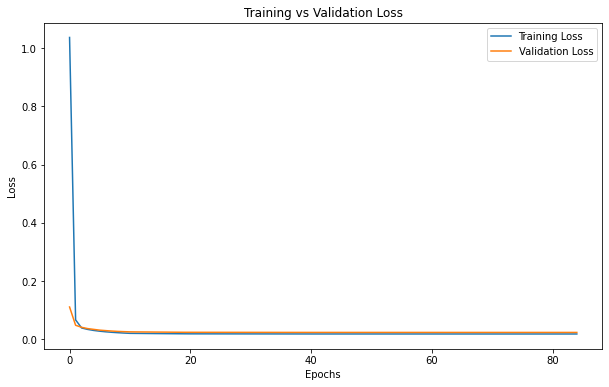

In [34]:
# Extract the loss values from the history object
training_loss = predict.history['loss']
validation_loss = predict.history['val_loss']

# Plotting the loss values
plt.figure(figsize=(10,6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [35]:
# save the model

model.save('./models/Best_models/model.5x6.h5')

In [36]:

gc.collect()

5254

In [37]:
losses = model.evaluate(X_train, {'xy': Y_train[:, :2], 'theta': Y_train[:, 2]}, batch_size=512)
print("Mean Squared Error For Train Dataset: ", losses)
gc.collect()
losses = model.evaluate(X_val, {'xy': Y_val[:, :2], 'theta': Y_val[:, 2]}, batch_size=32)
print("Mean Squared Error For Validation Dataset: ", losses)

5063/5063 [==============================] - 11s 2ms/step - loss: 0.0180 - xy_loss: 0.0098 - theta_loss: 0.0045 - xy_metric_function_xy_euclidean: 0.0098 - theta_metric_function_theta: 0.0478
Mean Squared Error For Train Dataset:  [0.01803727075457573, 0.009754756465554237, 0.004461575299501419, 0.009754793718457222, 0.04782993718981743]
9000/9000 [==============================] - 21s 2ms/step - loss: 0.0233 - xy_loss: 0.0131 - theta_loss: 0.0142 - xy_metric_function_xy_euclidean: 0.0131 - theta_metric_function_theta: 0.0651
Mean Squared Error For Validation Dataset:  [0.02333495393395424, 0.013148248195648193, 0.014202254824340343, 0.013148248195648193, 0.06506470590829849]


In [38]:

gc.collect()
losses = model.evaluate(X_test, {'xy': Y_test[:, :2], 'theta': Y_test[:, 2]}, batch_size=32)
print("Mean Squared Error For Test Dataset: ", losses)

313/313 [==============================] - 1s 2ms/step - loss: 0.0486 - xy_loss: 0.0128 - theta_loss: 0.0992 - xy_metric_function_xy_euclidean: 0.0128 - theta_metric_function_theta: 0.4145
Mean Squared Error For Test Dataset:  [0.04858572781085968, 0.01280562300235033, 0.09917116165161133, 0.012802109122276306, 0.41454049944877625]


In [39]:
gc.collect()

772

In [40]:
# print(y_pred_theta)
# print(Y_test[:, 2])
# print(theta_err)

313/313 [==============================] - 0s 1ms/step
[[-1.969949  ]
 [-0.6235178 ]
 [ 0.7634853 ]
 ...
 [ 0.24937256]
 [ 0.2829522 ]
 [ 0.85946304]]
Mean Error for test data (distance):  0.010581273604616987 meters/meters
Mean squared error for test data (degrees):  1.8305738443475357 radians/radians
#############################################################################################################
Mean Error for test data (degrees):  tf.Tensor(0.3850510006958952, shape=(), dtype=float64) radians/radians
Mean Error for test data (distance):  tf.Tensor(0.012805626052031482, shape=(), dtype=float64) meters
10000


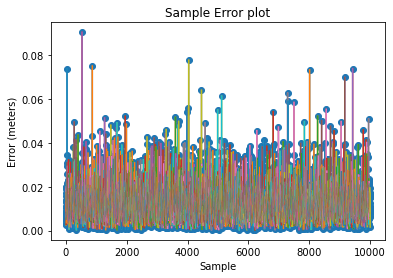

In [41]:
# Machine Learning - Make predictions

y_pred, theta_pred = model.predict(X_test)

y_pred_x = y_pred[:, 0]
y_pred_y = y_pred[:, 1]
y_pred_theta = theta_pred

# Round the predicted values to the nearest integer
print(y_pred_theta)

# Combine the predicted x and y values into a single array of (x, y) tuples
y_pred = np.stack((y_pred_x, y_pred_y), axis=1)

# Calculate accuracy score
mse = metrics.mean_squared_error(Y_test[:,:2], y_pred)

print("Mean Error for test data (distance): ", math.sqrt(mse), "meters/meters" )

mse = metrics.mean_squared_error(Y_test[:, 2], y_pred_theta)
print("Mean squared error for test data (degrees): ", math.sqrt(mse), "radians/radians" )

print("#############################################################################################################")

y_pred_theta = y_pred_theta.squeeze()
# print(Y_test[:, 2].shape)
# print(y_pred_theta.shape)
# def circular_mse(y_true, y_pred):
delta_angles = Y_test[:, 2] - y_pred_theta
# Wrap delta_angles to the [-pi, pi] range
wrapped_diff = tf.atan2(tf.sin(delta_angles), tf.cos(delta_angles))
theta_err = tf.reduce_mean(wrapped_diff)
print("Mean Error for test data (degrees): ", theta_err, "radians/radians" )

err = tf.reduce_mean(tf.sqrt(tf.square(Y_test[:, 0] - y_pred[:, 0]) + tf.square(Y_test[:, 1] - y_pred[:, 1])))
print("Mean Error for test data (distance): ", err, "meters")

# err = circular_mse(Y_test[:, 2], y_pred_theta)
# print("Mean Error for test data (degrees): ", err, "radians")


distance = (tf.sqrt(tf.square(Y_test[:, 0] - y_pred[:, 0]) + tf.square(Y_test[:, 1] - y_pred[:, 1])))

fig, ax = plt.subplots()

print(len(distance))

ax.scatter(range(len(distance)), distance)

ax.set_xlabel('Sample')
ax.set_ylabel('Error (meters)')
ax.set_title('Sample Error plot')


# Show lines between adjacent samples
for i in range(len(distance)-1):
    ax.plot([i, i+1], [distance[i], distance[i+1]], )

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


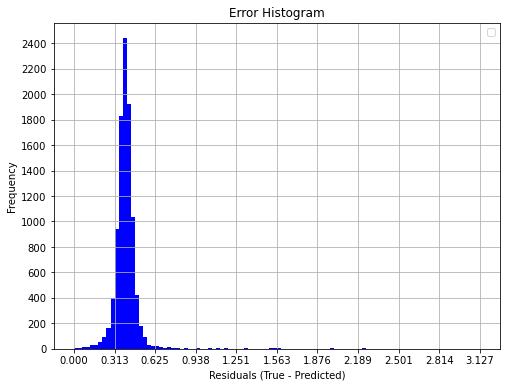

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


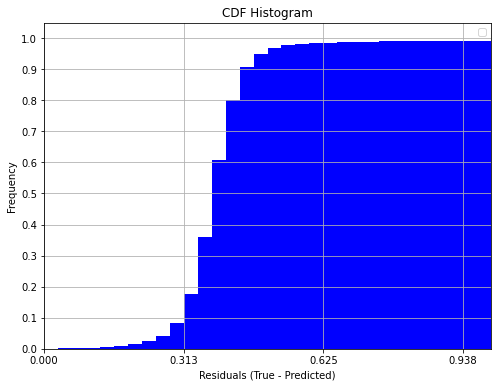

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
theta_err_total = wrapped_diff
# Assuming residuals_x and residuals_y are calculated as shown in the previous example
maxNumber = np.max(theta_err_total)
multiple = maxNumber / 10
plt.figure(figsize=(8, 6))
plt.hist(theta_err_total, bins=100, color='b', alpha=1, range=(0, maxNumber))
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error Histogram')
# plt.grid(True)
# plt.show()

plt.gca().xaxis.set_major_locator(MultipleLocator(multiple))
plt.gca().yaxis.set_major_locator(MultipleLocator(distance.shape[0]/50))

plt.grid(True)
plt.show()

maxNumber = np.max(theta_err_total)
multiple = maxNumber / 10
plt.figure(figsize=(8, 6))
plt.hist(theta_err_total, bins=100, color='b', alpha=1, cumulative=True, density=True, range=(0, maxNumber))
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.title('CDF Histogram')

plt.gca().xaxis.set_major_locator(MultipleLocator(multiple))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
plt.xlim([0, 1])
plt.grid(True)
plt.show()

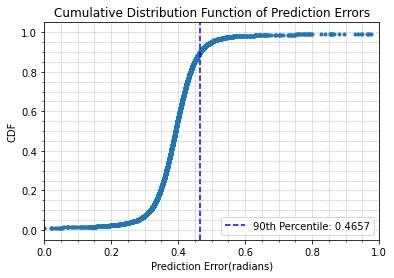

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the CDF
sorted_errors = np.sort(theta_err_total)
cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

# Plot
plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
plt.xlabel('Prediction Error(radians)')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Prediction Errors')
plt.grid(which='both', linestyle='--', linewidth=0.5)  # 'both' uses major and minor gridlines
plt.minorticks_on()

# This line will draw a vertical line at error=0.05.
# plt.axvline(0.05, color='red', linestyle='dashed')

# Draw a vertical line at the point where the CDF is 0.9:
error_90_percentile = np.percentile(sorted_errors, 90)
plt.axvline(error_90_percentile, color='blue', linestyle='dashed', label=f'90th Percentile: {error_90_percentile:.4f}')


# Adjust x-axis limits
plt.xlim([0, 1])

plt.legend()

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


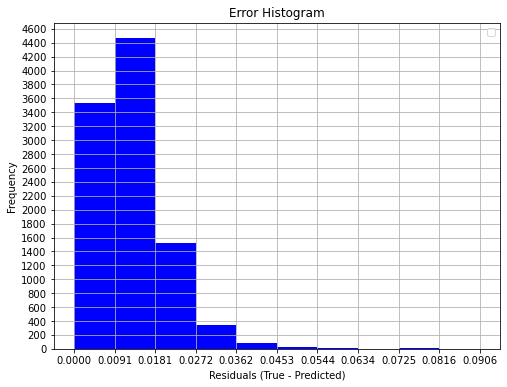

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


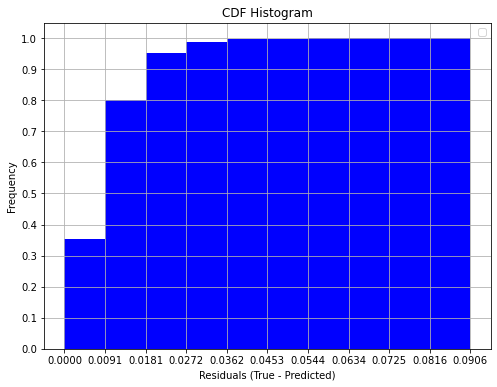

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Assuming residuals_x and residuals_y are calculated as shown in the previous example
maxNumber = np.max(distance)
multiple = maxNumber / 10
plt.figure(figsize=(8, 6))
plt.hist(distance, bins=10, color='b', alpha=1, range=(0, maxNumber))
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error Histogram')
# plt.grid(True)
# plt.show()

plt.gca().xaxis.set_major_locator(MultipleLocator(multiple))
plt.gca().yaxis.set_major_locator(MultipleLocator(distance.shape[0]/50))

plt.grid(True)
plt.show()

maxNumber = np.max(distance)
multiple = maxNumber / 10
plt.figure(figsize=(8, 6))
plt.hist(distance, bins=10, color='b', alpha=1, cumulative=True, density=True, range=(0, maxNumber))
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.title('CDF Histogram')

plt.gca().xaxis.set_major_locator(MultipleLocator(multiple))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))

plt.grid(True)
plt.show()

In [45]:
# Assuming y_true contains the true positions and y_pred contains the predicted positions
# Calculate the R-squared value

y_pred, theta_pred = model.predict(X_test)

y_pred_x = y_pred[:, 0]
y_pred_y = y_pred[:, 1]
y_pred_theta = theta_pred

# Round the predicted values to the nearest integer
# Combine the predicted x and y values into a single array of (x, y) tuples
y_pred = np.stack((y_pred_x, y_pred_y), axis=1)

r_squared = r2_score(Y_test[:, :2], y_pred)

print("R-squared (R^2):", r_squared)

# import matplotlib.pyplot as plt

# # Assuming y_true contains the true positions and y_pred contains the predicted positions
residuals_x = Y_test[:, 0] - y_pred[:, 0]
residuals_y = Y_test[:, 1] - y_pred[:, 1]


313/313 [==============================] - 1s 2ms/step
R-squared (R^2): 0.9999203160130556


313/313 [==============================] - 0s 1ms/step


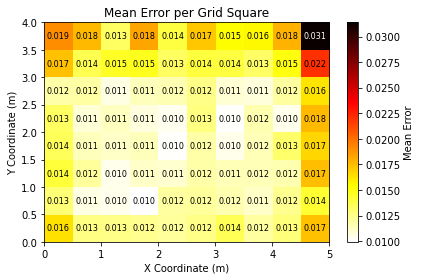

In [46]:
import numpy as np
import matplotlib.pyplot as plt

y_pred, theta_pred = model.predict(X_test)

x_pred = y_pred[:, 0]
y_pred = y_pred[:, 1]

grid_size = 0.50
x_bins = np.arange(0, 5 + grid_size, grid_size)
y_bins = np.arange(0, 3.6 + grid_size, grid_size)

errors = np.sqrt((x_pred - Y_test[:,0])**2 + (y_pred - Y_test[:,1])**2)

# errors = (tf.sqrt(tf.square(Y_test[:, 0] - y_pred[:, 0]) + tf.square(Y_test[:, 1] - y_pred[:, 1])))

# Use a 2D histogram to accumulate errors
grid_counts, x_edges, y_edges = np.histogram2d(Y_test[:,0], Y_test[:,1], bins=(x_bins, y_bins))
grid_errors, _, _ = np.histogram2d(Y_test[:,0], Y_test[:,1], bins=(x_bins, y_bins), weights=errors)

# Avoid division by zero for empty grid squares
grid_counts[grid_counts == 0] = 1

# Compute mean errors
mean_errors = grid_errors / grid_counts

# Visualize with a heatmap
fig, ax = plt.subplots()
cax = ax.imshow(mean_errors.T, origin='lower', 
           extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], 
           aspect='auto', cmap='hot_r')  # edgecolor and linewidth for borders

# Annotating each square with the error
for i in range(mean_errors.shape[0]):
    for j in range(mean_errors.shape[1]):
        ax.text(x_bins[i] + grid_size/2, y_bins[j] + grid_size/2,
                '{:.3f}'.format(mean_errors[i, j]), 
                ha='center', va='center', fontsize=8, color='white' if mean_errors[i, j] > 0.03 else 'black')

plt.colorbar(cax, label='Mean Error')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.title('Mean Error per Grid Square')
plt.tight_layout()
plt.show()

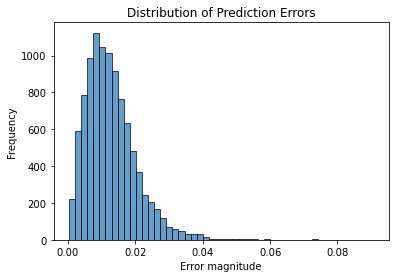

In [47]:
plt.hist(errors, bins=50, edgecolor="k", alpha=0.7)
plt.xlabel("Error magnitude")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


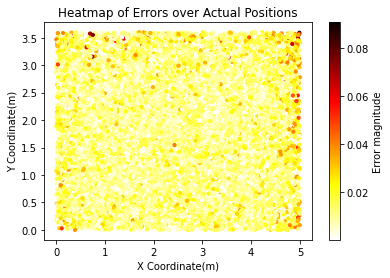

In [48]:
plt.scatter(Y_test[:,0], Y_test[:,1], c=errors, cmap='hot_r', s=10)
plt.colorbar(label="Error magnitude")
plt.xlabel("X Coordinate(m)")
plt.ylabel("Y Coordinate(m)")
plt.title("Heatmap of Errors over Actual Positions")
plt.show()


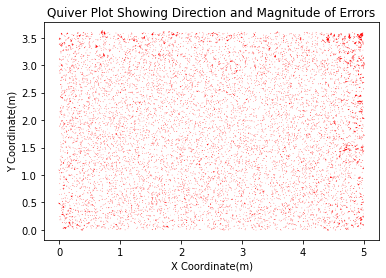

In [49]:
u = x_pred - Y_test[:,0]  # x component of error vectors
v = y_pred - Y_test[:,1]  # y component of error vectors

plt.quiver(Y_test[:,0], Y_test[:,1], u, v, angles='xy', scale_units='xy', scale=1, color='r', width=0.002)
plt.xlabel("X Coordinate(m)")
plt.ylabel("Y Coordinate(m)")
plt.title("Quiver Plot Showing Direction and Magnitude of Errors")
plt.show()

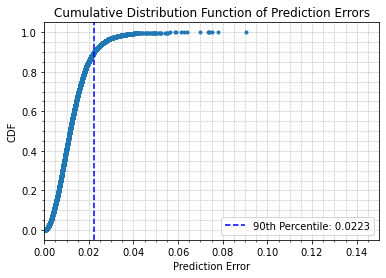

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the CDF
sorted_errors = np.sort(errors)
cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

# Plot
plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
plt.xlabel('Prediction Error')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Prediction Errors')
plt.grid(which='both', linestyle='--', linewidth=0.5)  # 'both' uses major and minor gridlines
plt.minorticks_on()

# This line will draw a vertical line at error=0.05.
# plt.axvline(0.05, color='red', linestyle='dashed')

# If you intended to draw a vertical line at the point where the CDF is 0.9:
error_90_percentile = np.percentile(sorted_errors, 90)
plt.axvline(error_90_percentile, color='blue', linestyle='dashed', label=f'90th Percentile: {error_90_percentile:.4f}')

# Adjust x-axis limits
plt.xlim([0, 0.15])

plt.legend()

plt.show()



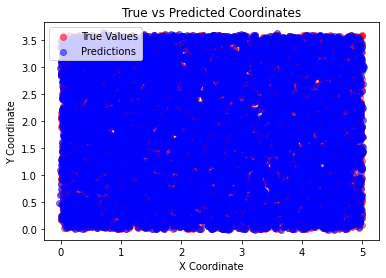

In [51]:
plt.scatter(Y_test[:,0], Y_test[:,1], c='red', label="True Values", alpha=0.5)
plt.scatter(x_pred, y_pred, c='blue', label="Predictions", alpha=0.5)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.title("True vs Predicted Coordinates")
plt.show()

313/313 [==============================] - 0s 1ms/step
[[-1.969949  ]
 [-0.6235178 ]
 [ 0.7634853 ]
 ...
 [ 0.24937256]
 [ 0.2829522 ]
 [ 0.85946304]]
(10000,)
2500


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


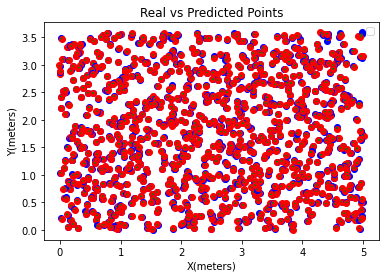

In [52]:

# Assume you have a trained model called "model"
# and a test set called X_test and y_test

# Make predictions on the test set
# y_pred, theta_pred = model.predict(X_test)

# Create a scatter plot showing the real points in blue
# plt.scatter(Y_test[:,0], Y_test[:,1], color='blue', label='Real Points')
y_pred, theta_pred = model.predict(X_test)

x_pred = y_pred[:, 0]
y_pred = y_pred[:, 1]

print(theta_pred)
print(y_pred.shape)

# Create a scatter plot showing the predicted points in red
# plt.scatter(x_pred, y_pred, color='red', label='Predicted Points')
number_for_plot = int(x_pred.shape[0]/4)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print(number_for_plot)
# Loop through each point in the test set
for i in range(0 , 1000):
    k = i * 1
    # percentage = (i/number_for_plot)*100
    # print(percentage)
    # Get the x and y coordinates for the real and predicted points
    x_real, y_real, theta_real = Y_test[k]
    x_pred_arrow = x_pred[k]
    y_pred_arrow = y_pred[k]
    plt.scatter(x_real, y_real, color='blue')
    plt.scatter(x_pred_arrow, y_pred_arrow, color='red')
    # Add an arrow from the real point to the predicted point
    plt.arrow(x_real, y_real, x_pred_arrow - x_real, y_pred_arrow - y_real, 
              length_includes_head=True, head_width=0.01, color='green')
    
# Set the x-axis label to "X"
plt.xlabel('X(meters)')

# Set the y-axis label to "Y"
plt.ylabel('Y(meters)')

# Set the title of the plot to "Real vs Predicted Points"
plt.title('Real vs Predicted Points')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [53]:
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")
#     plt.legend(loc="best")
#     return plt

In [54]:
# from sklearn.linear_model import LinearRegression

# # Create a LinearRegression object
# lr = LinearRegression()

# # Plot the learning curve
# plot_learning_curve(lr, "Linear Regression", X, Y, cv=5)
# plt.show()

# plt.savefig('plot.png')
# print('Break Point')


# plot_learning_curve(lr, "Linear Regression", X, Y, cv=5)
# plt.ylim(-5, 1.1)
# plt.show() 